In [1]:
import cv2
import pandas as pd
from glob import glob
import numpy as np
import shap

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model

import keras.backend as K

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# make data_list
image_class = []
image_path = []

for train_dir in glob("training/*"):
    monkey_class = train_dir.split("/")[1]
    for path in glob(train_dir + "/*"):
        image_class.append(monkey_class)
        image_path.append(path)
        
data_list = pd.DataFrame({"class": image_class, "image_path": image_path})

In [3]:
data_list = shuffle(data_list)
data_list = data_list.reset_index(drop=True)

In [4]:
X_image = data_list["image_path"]
y_list = data_list["class"]

image = [cv2.imread(i) for i in X_image]
image = [cv2.resize(i, (224,224)) for i in image]
image = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in image]
    
y = pd.get_dummies(y_list)

In [12]:
# load pre-trained model
based_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in based_model.layers:
    layer.trainable = False
x = based_model.output
x = Flatten()(x)
prediction = Dense(10, activation = "softmax")(x)

model = Model(input=based_model.input, output = prediction)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(np.array(image), y, test_size=0.25)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


optimizer = keras.optimizers.Adam(lr=10e-5)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = 50,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [earlystop])

Epoch 1/50
26/26 [==============================] - 7s 284ms/step - loss: 11.8719 - acc: 0.1632 - val_loss: 10.9628 - val_acc: 0.2145
Epoch 2/50
26/26 [==============================] - 7s 256ms/step - loss: 9.8658 - acc: 0.2690 - val_loss: 8.3188 - val_acc: 0.3636
Epoch 3/50
26/26 [==============================] - 7s 258ms/step - loss: 7.4854 - acc: 0.4051 - val_loss: 5.8554 - val_acc: 0.5236
Epoch 4/50
26/26 [==============================] - 7s 257ms/step - loss: 5.8411 - acc: 0.5071 - val_loss: 4.6935 - val_acc: 0.6218
Epoch 5/50
26/26 [==============================] - 7s 260ms/step - loss: 4.8779 - acc: 0.5682 - val_loss: 3.4427 - val_acc: 0.6945
Epoch 6/50
26/26 [==============================] - 7s 253ms/step - loss: 3.6754 - acc: 0.6561 - val_loss: 2.8419 - val_acc: 0.7491
Epoch 7/50
26/26 [==============================] - 7s 253ms/step - loss: 3.3239 - acc: 0.6830 - val_loss: 2.6385 - val_acc: 0.7673
Epoch 8/50
26/26 [==============================] - 7s 256ms/step - loss: 

In [34]:
input_set = [20,800]
to_explain = np.array(image, dtype=float)[input_set]
print(y_list[input_set])


20     n6
800    n8
Name: class, dtype: object


In [35]:
model.layers[8]

In [36]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

layer_check = 8 # 2, 9, 16
explainer = shap.GradientExplainer((model.layers[layer_check].input, model.layers[-1].output), map2layer(preprocess_input(np.array(image)[:100].copy()), layer_check))
shap_values,indexes = explainer.shap_values(map2layer(to_explain, layer_check), ranked_outputs=2)


In [37]:
(model.layers[layer_check].input, model.layers[-1].output)

(<tf.Tensor 'block3_conv1/Relu:0' shape=(?, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'dense_1/Softmax:0' shape=(?, 10) dtype=float32>)

In [38]:
# get the names for the classes
index_names = [["n" + str(indexes[0][0]), "n" + str(indexes[0][1])], ["n" + str(indexes[1][0]), "n" + str(indexes[1][1])]]
index_names = np.array(index_names)



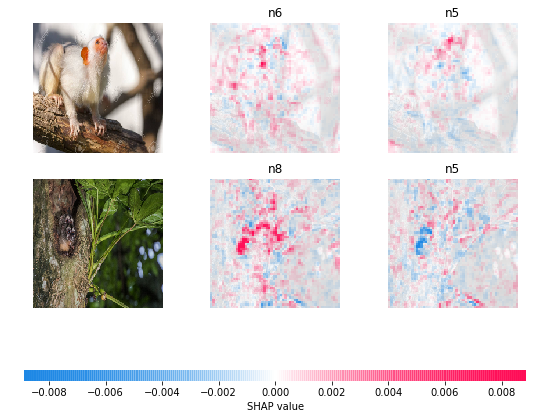

In [39]:
shap.image_plot(shap_values, to_explain, index_names)